In [ ]:
# %%

# Use Google Colab
use_google_colab = False
# Process the training dataset
training_data_processing = False
# Train the model
model_training = True
# Validation the model
model_validation = True
# Load the model from your Google Drive or local file system
model_loading = False

import numpy as np
import torch

from util.cuda import cuda
from util.gpu_info import gpuInfo
from util.data_augmentation import training_data_loading, training_data_augmentation
from util.loss import BCEIoULoss
from util.training import train
from util.testing import submission_creating, test

from networks.LinkNetB7 import *
from networks.DLinkNet34 import *
from networks.DLinkNet50 import *
from networks.DLinkNet101 import *
from networks.LinkNet34 import *
from networks.UNet import *


path_training = "./training/"
path_testing = "./test/"
path_data = "./data/"
path_model = "./models/DLinkNet101.model"

cuda_available = torch.cuda.is_available()
if cuda_available:
    print("CUDA is available. Utilize GPUs for computation")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Utilize CPUs for computation.")
    device = torch.device("cpu")

gpu_info = gpuInfo()

model = DLinkNet101()

if cuda_available:
    model.cuda()
print(model)

CUDA is available. Utilize GPUs for computation
Fri Nov  8 08:42:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080        Off |   00000000:01:00.0  On |                  N/A |
|  0%   46C    P8             16W /  340W |     633MiB /  16376MiB |     10%      Default |
|                                         |                        |                  N/A |


/home/wesley/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wesley/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DLinkNet101(
  (input_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256

In [ ]:
# %%

# The resolution of resized training images and the corresponding masks
training_resize = 512
# The number of resized training pairs used for data augmentation
training_number = 367
# The resolution of resized testing images
testing_resize = int(608 * training_resize / 400)
if testing_resize % 2 == 1:
    testing_resize += 1

if training_data_processing:
    # Load and generate the resized training dataset and validation dataset
    images_training, labels_training, images_validation, labels_validation = (
        training_data_loading(path_training, training_resize, training_number)
    )
    # Generate the augmented training dataset
    rotations = [0, 45, 90, 135]  # the rotation angle

    flips = ["original", np.flipud, np.fliplr]  # 'original', np.flipud, np.fliplr

    shifts = [(-16, 16)]

    images_augmented, labels_augmented = training_data_augmentation(
        images_training, labels_training, rotations, flips, shifts, training_resize
    )
    # Save the augmented training dataset and resized validation dataset
    # to your Google Drive or local file system
    np.save(f"{path_data}images_training", images_augmented)
    np.save(f"{path_data}labels_training", labels_augmented)
    np.save(f"{path_data}images_validation", images_validation)
    np.save(f"{path_data}labels_validation", labels_validation)
elif not model_loading:
    # Load the augmented training dataset and resized validation dataset
    # from your Google Drive or local file system
    images_augmented = np.load(f"{path_data}images_training.npy")
    labels_augmented = np.load(f"{path_data}labels_training.npy")
    images_validation = np.load(f"{path_data}images_validation.npy")
    labels_validation = np.load(f"{path_data}labels_validation.npy")

if model_training:
    print(f"\nimages_training.shape = {images_augmented.shape}")
    print(f"labels_training.shape = {labels_augmented.shape}")
    print(f"images_validation.shape = {images_validation.shape}")
    print(f"labels_validation.shape = {labels_validation.shape}")


images_training.shape = (6264, 3, 512, 512)
labels_training.shape = (6264, 1, 512, 512)
images_validation.shape = (224, 3, 512, 512)
labels_validation.shape = (224, 1, 512, 512)


/home/wesley/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]


---------Training for Epoch 1 starting:---------
→ Running_loss for Batch 1: 0.39146825671195984
→ ACC for Batch 1: 0.9360876083374023
→ Running_loss for Batch 21: 0.39379775524139404
→ ACC for Batch 21: 0.9961652755737305
→ Running_loss for Batch 41: 0.31007593870162964
→ ACC for Batch 41: 0.9677858352661133
→ Running_loss for Batch 61: 0.290634423494339
→ ACC for Batch 61: 0.9752101898193359
→ Running_loss for Batch 81: 0.277852863073349
→ ACC for Batch 81: 0.971989631652832
→ Running_loss for Batch 101: 0.2174728363752365
→ ACC for Batch 101: 0.9770078659057617
→ Running_loss for Batch 121: 0.2831436097621918
→ ACC for Batch 121: 0.9667091369628906
→ Running_loss for Batch 141: 0.34423238039016724
→ ACC for Batch 141: 0.9489946365356445
→ Running_loss for Batch 161: 0.2383781522512436
→ ACC for Batch 161: 0.9693307876586914
→ Running_loss for Batch 181: 0.23129822313785553
→ ACC for Batch 181: 0.9759368896484375
→ Running_loss for Batch 201: 0.2259676456451416
→ ACC for Batch 201: 

  5%|▌         | 1/20 [15:03<4:46:04, 903.37s/it]


---------Training for Epoch 2 starting:---------
→ Running_loss for Batch 1: 0.1884986162185669
→ ACC for Batch 1: 0.989253044128418
→ Running_loss for Batch 21: 0.22675123810768127
→ ACC for Batch 21: 0.9841175079345703
→ Running_loss for Batch 41: 0.1953989714384079
→ ACC for Batch 41: 0.9902677536010742
→ Running_loss for Batch 61: 0.1866425722837448
→ ACC for Batch 61: 0.9849910736083984
→ Running_loss for Batch 81: 0.186416894197464
→ ACC for Batch 81: 0.9840812683105469
→ Running_loss for Batch 101: 0.19482973217964172
→ ACC for Batch 101: 0.9688644409179688
→ Running_loss for Batch 121: 0.1603350043296814
→ ACC for Batch 121: 0.9760942459106445
→ Running_loss for Batch 141: 0.14052243530750275
→ ACC for Batch 141: 0.9885492324829102
→ Running_loss for Batch 161: 0.12827345728874207
→ ACC for Batch 161: 0.9816627502441406
→ Running_loss for Batch 181: 0.1569048911333084
→ ACC for Batch 181: 0.9696512222290039
→ Running_loss for Batch 201: 0.20949973165988922
→ ACC for Batch 201:

 10%|█         | 2/20 [25:06<3:37:59, 726.62s/it]


---------Training for Epoch 3 starting:---------
→ Running_loss for Batch 1: 0.18402594327926636
→ ACC for Batch 1: 0.9816274642944336
→ Running_loss for Batch 21: 0.16323624551296234
→ ACC for Batch 21: 0.9877853393554688
→ Running_loss for Batch 41: 0.19161301851272583
→ ACC for Batch 41: 0.9777793884277344
→ Running_loss for Batch 61: 0.1329236626625061
→ ACC for Batch 61: 0.9876194000244141
→ Running_loss for Batch 81: 0.1657610684633255
→ ACC for Batch 81: 0.9889888763427734
→ Running_loss for Batch 101: 0.15996399521827698
→ ACC for Batch 101: 0.9904575347900391
→ Running_loss for Batch 121: 0.15133361518383026
→ ACC for Batch 121: 0.9910106658935547
→ Running_loss for Batch 141: 0.19455283880233765
→ ACC for Batch 141: 0.9866113662719727
→ Running_loss for Batch 161: 0.14973783493041992
→ ACC for Batch 161: 0.979802131652832
→ Running_loss for Batch 181: 0.1401115357875824
→ ACC for Batch 181: 0.9878635406494141
→ Running_loss for Batch 201: 0.1552305519580841
→ ACC for Batch 2

 15%|█▌        | 3/20 [35:03<3:09:08, 667.55s/it]


---------Training for Epoch 4 starting:---------
→ Running_loss for Batch 1: 0.1291884481906891
→ ACC for Batch 1: 0.9839076995849609
→ Running_loss for Batch 21: 0.1413392722606659
→ ACC for Batch 21: 0.9902057647705078
→ Running_loss for Batch 41: 0.13756483793258667
→ ACC for Batch 41: 0.9841690063476562
→ Running_loss for Batch 61: 0.1301802694797516
→ ACC for Batch 61: 0.9856138229370117
→ Running_loss for Batch 81: 0.15106269717216492
→ ACC for Batch 81: 0.9933595657348633
→ Running_loss for Batch 101: 0.14737296104431152
→ ACC for Batch 101: 0.9854917526245117
→ Running_loss for Batch 121: 0.14459392428398132
→ ACC for Batch 121: 0.9943780899047852
→ Running_loss for Batch 141: 0.13349121809005737
→ ACC for Batch 141: 0.9886159896850586
→ Running_loss for Batch 161: 0.15352679789066315
→ ACC for Batch 161: 0.9901666641235352
→ Running_loss for Batch 181: 0.18581432104110718
→ ACC for Batch 181: 0.9883127212524414
→ Running_loss for Batch 201: 0.14387981593608856
→ ACC for Batch

 20%|██        | 4/20 [44:57<2:50:16, 638.56s/it]


---------Training for Epoch 5 starting:---------
→ Running_loss for Batch 1: 0.1697186976671219
→ ACC for Batch 1: 0.9812202453613281
→ Running_loss for Batch 21: 0.1331111341714859
→ ACC for Batch 21: 0.9821281433105469
→ Running_loss for Batch 41: 0.13818944990634918
→ ACC for Batch 41: 0.9889659881591797
→ Running_loss for Batch 61: 0.15642642974853516
→ ACC for Batch 61: 0.9921369552612305
→ Running_loss for Batch 81: 0.18221630156040192
→ ACC for Batch 81: 0.9726009368896484
→ Running_loss for Batch 101: 0.1539786010980606
→ ACC for Batch 101: 0.9829931259155273
→ Running_loss for Batch 121: 0.1729659140110016
→ ACC for Batch 121: 0.9868192672729492
→ Running_loss for Batch 141: 0.16502131521701813
→ ACC for Batch 141: 0.9862995147705078
→ Running_loss for Batch 161: 0.13649755716323853
→ ACC for Batch 161: 0.9814310073852539
→ Running_loss for Batch 181: 0.1565052717924118
→ ACC for Batch 181: 0.9837570190429688
→ Running_loss for Batch 201: 0.15587644279003143
→ ACC for Batch 2

 25%|██▌       | 5/20 [54:42<2:34:49, 619.28s/it]


---------Training for Epoch 6 starting:---------
→ Running_loss for Batch 1: 0.12527750432491302
→ ACC for Batch 1: 0.9911184310913086
→ Running_loss for Batch 21: 0.10224290192127228
→ ACC for Batch 21: 0.9833364486694336
→ Running_loss for Batch 41: 0.15327921509742737
→ ACC for Batch 41: 0.9873790740966797
→ Running_loss for Batch 61: 0.12486898899078369
→ ACC for Batch 61: 0.9872493743896484
→ Running_loss for Batch 81: 0.14221136271953583
→ ACC for Batch 81: 0.9947376251220703
→ Running_loss for Batch 101: 0.1587694138288498
→ ACC for Batch 101: 0.9929285049438477
→ Running_loss for Batch 121: 0.1785995364189148
→ ACC for Batch 121: 0.996800422668457
→ Running_loss for Batch 141: 0.11342499405145645
→ ACC for Batch 141: 0.9906597137451172
→ Running_loss for Batch 161: 0.1707189977169037
→ ACC for Batch 161: 0.9783382415771484
→ Running_loss for Batch 181: 0.14738978445529938
→ ACC for Batch 181: 0.9815273284912109
→ Running_loss for Batch 201: 0.13760624825954437
→ ACC for Batch 

 30%|███       | 6/20 [1:04:28<2:21:50, 607.90s/it]


---------Training for Epoch 7 starting:---------
→ Running_loss for Batch 1: 0.13742181658744812
→ ACC for Batch 1: 0.9934043884277344
→ Running_loss for Batch 21: 0.14880356192588806
→ ACC for Batch 21: 0.9953689575195312
→ Running_loss for Batch 41: 0.13694553077220917
→ ACC for Batch 41: 0.9827690124511719
→ Running_loss for Batch 61: 0.13011613488197327
→ ACC for Batch 61: 0.9830694198608398
→ Running_loss for Batch 81: 0.1264180839061737
→ ACC for Batch 81: 0.9925928115844727
→ Running_loss for Batch 101: 0.14387337863445282
→ ACC for Batch 101: 0.986790657043457
→ Running_loss for Batch 121: 0.12685242295265198
→ ACC for Batch 121: 0.9821195602416992
→ Running_loss for Batch 141: 0.15787236392498016
→ ACC for Batch 141: 0.9868297576904297
→ Running_loss for Batch 161: 0.12988190352916718
→ ACC for Batch 161: 0.9924402236938477
→ Running_loss for Batch 181: 0.12568728625774384
→ ACC for Batch 181: 0.9928674697875977
→ Running_loss for Batch 201: 0.13151103258132935
→ ACC for Batc

 35%|███▌      | 7/20 [1:14:25<2:10:54, 604.16s/it]


---------Training for Epoch 8 starting:---------
→ Running_loss for Batch 1: 0.10219019651412964
→ ACC for Batch 1: 0.989262580871582
→ Running_loss for Batch 21: 0.12805026769638062
→ ACC for Batch 21: 0.9875879287719727
→ Running_loss for Batch 41: 0.13871845602989197
→ ACC for Batch 41: 0.9921941757202148
→ Running_loss for Batch 61: 0.1250060796737671
→ ACC for Batch 61: 0.9877662658691406
→ Running_loss for Batch 81: 0.09234503656625748
→ ACC for Batch 81: 0.9866790771484375
→ Running_loss for Batch 101: 0.1619710475206375
→ ACC for Batch 101: 0.9904308319091797
→ Running_loss for Batch 121: 0.11251223832368851
→ ACC for Batch 121: 0.9855880737304688
→ Running_loss for Batch 141: 0.11177635192871094
→ ACC for Batch 141: 0.9871540069580078
→ Running_loss for Batch 161: 0.1297062784433365
→ ACC for Batch 161: 0.9855642318725586
→ Running_loss for Batch 181: 0.09371591359376907
→ ACC for Batch 181: 0.9873695373535156
→ Running_loss for Batch 201: 0.1418224573135376
→ ACC for Batch 2

 40%|████      | 8/20 [1:24:17<2:00:04, 600.36s/it]


---------Training for Epoch 9 starting:---------
→ Running_loss for Batch 1: 0.13328638672828674
→ ACC for Batch 1: 0.9935951232910156
→ Running_loss for Batch 21: 0.14781907200813293
→ ACC for Batch 21: 0.9841680526733398
→ Running_loss for Batch 41: 0.11314153671264648
→ ACC for Batch 41: 0.9901103973388672
→ Running_loss for Batch 61: 0.13015004992485046
→ ACC for Batch 61: 0.993952751159668
→ Running_loss for Batch 81: 0.1381414830684662
→ ACC for Batch 81: 0.9901399612426758
→ Running_loss for Batch 101: 0.1329452097415924
→ ACC for Batch 101: 0.9931650161743164
→ Running_loss for Batch 121: 0.10354536026716232
→ ACC for Batch 121: 0.9799709320068359
→ Running_loss for Batch 141: 0.1672798991203308
→ ACC for Batch 141: 0.9878530502319336
→ Running_loss for Batch 161: 0.10046030580997467
→ ACC for Batch 161: 0.9863595962524414
→ Running_loss for Batch 181: 0.1336095780134201
→ ACC for Batch 181: 0.9919509887695312
→ Running_loss for Batch 201: 0.13369889557361603
→ ACC for Batch 2

 45%|████▌     | 9/20 [1:34:05<1:49:22, 596.61s/it]


---------Training for Epoch 10 starting:---------
→ Running_loss for Batch 1: 0.1568761020898819
→ ACC for Batch 1: 0.9835386276245117
→ Running_loss for Batch 21: 0.1511421650648117
→ ACC for Batch 21: 0.982213020324707
→ Running_loss for Batch 41: 0.11826254427433014
→ ACC for Batch 41: 0.9913396835327148
→ Running_loss for Batch 61: 0.11929728835821152
→ ACC for Batch 61: 0.9930381774902344
→ Running_loss for Batch 81: 0.09916236996650696
→ ACC for Batch 81: 0.9890232086181641
→ Running_loss for Batch 101: 0.1363118588924408
→ ACC for Batch 101: 0.988983154296875
→ Running_loss for Batch 121: 0.15592631697654724
→ ACC for Batch 121: 0.9887971878051758
→ Running_loss for Batch 141: 0.11774863302707672
→ ACC for Batch 141: 0.9900455474853516
→ Running_loss for Batch 161: 0.11693096905946732
→ ACC for Batch 161: 0.9904575347900391
→ Running_loss for Batch 181: 0.10675081610679626
→ ACC for Batch 181: 0.9924068450927734
→ Running_loss for Batch 201: 0.13675029575824738
→ ACC for Batch 

 50%|█████     | 10/20 [1:43:44<1:38:32, 591.26s/it]


---------Training for Epoch 11 starting:---------
→ Running_loss for Batch 1: 0.14489206671714783
→ ACC for Batch 1: 0.9943990707397461
→ Running_loss for Batch 21: 0.1302131563425064
→ ACC for Batch 21: 0.9818859100341797
→ Running_loss for Batch 41: 0.11452329158782959
→ ACC for Batch 41: 0.989802360534668
→ Running_loss for Batch 61: 0.09429872035980225
→ ACC for Batch 61: 0.9888067245483398
→ Running_loss for Batch 81: 0.10706206411123276
→ ACC for Batch 81: 0.9884433746337891
→ Running_loss for Batch 101: 0.13307590782642365
→ ACC for Batch 101: 0.9910221099853516
→ Running_loss for Batch 121: 0.10458019375801086
→ ACC for Batch 121: 0.9916582107543945
→ Running_loss for Batch 141: 0.08757708966732025
→ ACC for Batch 141: 0.9940948486328125
→ Running_loss for Batch 161: 0.11118581891059875
→ ACC for Batch 161: 0.9962015151977539
→ Running_loss for Batch 181: 0.08400050550699234
→ ACC for Batch 181: 0.9870882034301758
→ Running_loss for Batch 201: 0.10821107774972916
→ ACC for Bat

 55%|█████▌    | 11/20 [1:53:29<1:28:22, 589.13s/it]


---------Training for Epoch 12 starting:---------
→ Running_loss for Batch 1: 0.09695374220609665
→ ACC for Batch 1: 0.9949865341186523
→ Running_loss for Batch 21: 0.08089419454336166
→ ACC for Batch 21: 0.9933452606201172
→ Running_loss for Batch 41: 0.08192665874958038
→ ACC for Batch 41: 0.9940557479858398
→ Running_loss for Batch 61: 0.08805598318576813
→ ACC for Batch 61: 0.9922304153442383
→ Running_loss for Batch 81: 0.10529741644859314
→ ACC for Batch 81: 0.9970064163208008
→ Running_loss for Batch 101: 0.09745727479457855
→ ACC for Batch 101: 0.9927644729614258
→ Running_loss for Batch 121: 0.13291463255882263
→ ACC for Batch 121: 0.9947433471679688
→ Running_loss for Batch 141: 0.10063264518976212
→ ACC for Batch 141: 0.9943008422851562
→ Running_loss for Batch 161: 0.08877258002758026
→ ACC for Batch 161: 0.9946718215942383
→ Running_loss for Batch 181: 0.10012645274400711
→ ACC for Batch 181: 0.9878292083740234
→ Running_loss for Batch 201: 0.1228727176785469
→ ACC for Ba

 60%|██████    | 12/20 [2:03:05<1:18:01, 585.20s/it]


---------Training for Epoch 13 starting:---------
→ Running_loss for Batch 1: 0.08980844169855118
→ ACC for Batch 1: 0.9927501678466797
→ Running_loss for Batch 21: 0.08160049468278885
→ ACC for Batch 21: 0.9884366989135742
→ Running_loss for Batch 41: 0.11219894886016846
→ ACC for Batch 41: 0.9948244094848633
→ Running_loss for Batch 61: 0.1035255640745163
→ ACC for Batch 61: 0.9849023818969727
→ Running_loss for Batch 81: 0.08334037661552429
→ ACC for Batch 81: 0.9891386032104492
→ Running_loss for Batch 101: 0.10665313154459
→ ACC for Batch 101: 0.9929676055908203
→ Running_loss for Batch 121: 0.12453615665435791
→ ACC for Batch 121: 0.9928083419799805
→ Running_loss for Batch 141: 0.10574012994766235
→ ACC for Batch 141: 0.9922294616699219
→ Running_loss for Batch 161: 0.07994537055492401
→ ACC for Batch 161: 0.9934568405151367
→ Running_loss for Batch 181: 0.08914870768785477
→ ACC for Batch 181: 0.9929418563842773
→ Running_loss for Batch 201: 0.09894513338804245
→ ACC for Batch

 65%|██████▌   | 13/20 [2:12:42<1:07:59, 582.79s/it]


---------Training for Epoch 14 starting:---------
→ Running_loss for Batch 1: 0.07089000940322876
→ ACC for Batch 1: 0.991703987121582
→ Running_loss for Batch 21: 0.09577368944883347
→ ACC for Batch 21: 0.979985237121582
→ Running_loss for Batch 41: 0.07838337868452072
→ ACC for Batch 41: 0.9937639236450195
→ Running_loss for Batch 61: 0.10477010905742645
→ ACC for Batch 61: 0.9949922561645508
→ Running_loss for Batch 81: 0.09602578729391098
→ ACC for Batch 81: 0.997401237487793
→ Running_loss for Batch 101: 0.07021394371986389
→ ACC for Batch 101: 0.9899787902832031
→ Running_loss for Batch 121: 0.08855756372213364
→ ACC for Batch 121: 0.9917192459106445
→ Running_loss for Batch 141: 0.09911054372787476
→ ACC for Batch 141: 0.9929904937744141
→ Running_loss for Batch 161: 0.07897582650184631
→ ACC for Batch 161: 0.9966650009155273
→ Running_loss for Batch 181: 0.09913577139377594
→ ACC for Batch 181: 0.9895792007446289
→ Running_loss for Batch 201: 0.07641826570034027
→ ACC for Batc

 70%|███████   | 14/20 [2:22:34<58:33, 585.57s/it]  


---------Training for Epoch 15 starting:---------
→ Running_loss for Batch 1: 0.08678872883319855
→ ACC for Batch 1: 0.9924497604370117
→ Running_loss for Batch 21: 0.0969151183962822
→ ACC for Batch 21: 0.9913368225097656
→ Running_loss for Batch 41: 0.0683809444308281
→ ACC for Batch 41: 0.9893836975097656
→ Running_loss for Batch 61: 0.10082024335861206
→ ACC for Batch 61: 0.9886255264282227
→ Running_loss for Batch 81: 0.07553855329751968
→ ACC for Batch 81: 0.9933605194091797
→ Running_loss for Batch 101: 0.058829206973314285
→ ACC for Batch 101: 0.9956398010253906
→ Running_loss for Batch 121: 0.10103239119052887
→ ACC for Batch 121: 0.9890956878662109
→ Running_loss for Batch 141: 0.09998485445976257
→ ACC for Batch 141: 0.9893875122070312
→ Running_loss for Batch 161: 0.07603596150875092
→ ACC for Batch 161: 0.9956207275390625
→ Running_loss for Batch 181: 0.07976476848125458
→ ACC for Batch 181: 0.9882001876831055
→ Running_loss for Batch 201: 0.09048480540513992
→ ACC for Ba

 75%|███████▌  | 15/20 [2:32:27<48:58, 587.63s/it]


---------Training for Epoch 16 starting:---------
→ Running_loss for Batch 1: 0.07784665375947952
→ ACC for Batch 1: 0.9960479736328125
→ Running_loss for Batch 21: 0.10427416115999222
→ ACC for Batch 21: 0.9953927993774414
→ Running_loss for Batch 41: 0.08969452977180481
→ ACC for Batch 41: 0.9905862808227539
→ Running_loss for Batch 61: 0.08288493007421494
→ ACC for Batch 61: 0.995814323425293
→ Running_loss for Batch 81: 0.07237022370100021
→ ACC for Batch 81: 0.987584114074707
→ Running_loss for Batch 101: 0.07972145825624466
→ ACC for Batch 101: 0.9941205978393555
→ Running_loss for Batch 121: 0.11042071133852005
→ ACC for Batch 121: 0.990168571472168
→ Running_loss for Batch 141: 0.06299490481615067
→ ACC for Batch 141: 0.9959564208984375
→ Running_loss for Batch 161: 0.06917252391576767
→ ACC for Batch 161: 0.9937477111816406
→ Running_loss for Batch 181: 0.07857760787010193
→ ACC for Batch 181: 0.9928560256958008
→ Running_loss for Batch 201: 0.07726812362670898
→ ACC for Batc

 80%|████████  | 16/20 [2:42:01<38:55, 583.79s/it]


---------Training for Epoch 17 starting:---------
→ Running_loss for Batch 1: 0.0924488827586174
→ ACC for Batch 1: 0.9888744354248047
→ Running_loss for Batch 21: 0.08596212416887283
→ ACC for Batch 21: 0.9903554916381836
→ Running_loss for Batch 41: 0.08351028710603714
→ ACC for Batch 41: 0.9921159744262695
→ Running_loss for Batch 61: 0.13306924700737
→ ACC for Batch 61: 0.9825305938720703
→ Running_loss for Batch 81: 0.07704514265060425
→ ACC for Batch 81: 0.9958486557006836
→ Running_loss for Batch 101: 0.08196187764406204
→ ACC for Batch 101: 0.99090576171875
→ Running_loss for Batch 121: 0.09021841734647751
→ ACC for Batch 121: 0.9930734634399414
→ Running_loss for Batch 141: 0.10455792397260666
→ ACC for Batch 141: 0.9954910278320312
→ Running_loss for Batch 161: 0.0761207640171051
→ ACC for Batch 161: 0.9897336959838867
→ Running_loss for Batch 181: 0.07912562042474747
→ ACC for Batch 181: 0.997279167175293
→ Running_loss for Batch 201: 0.10190471261739731
→ ACC for Batch 201

 85%|████████▌ | 17/20 [2:51:35<29:02, 580.79s/it]


---------Training for Epoch 18 starting:---------
→ Running_loss for Batch 1: 0.07271646708250046
→ ACC for Batch 1: 0.9946556091308594
→ Running_loss for Batch 21: 0.07996538281440735
→ ACC for Batch 21: 0.9914751052856445
→ Running_loss for Batch 41: 0.06833312660455704
→ ACC for Batch 41: 0.9951553344726562
→ Running_loss for Batch 61: 0.09594737738370895
→ ACC for Batch 61: 0.9976339340209961
→ Running_loss for Batch 81: 0.08627676218748093
→ ACC for Batch 81: 0.9948701858520508
→ Running_loss for Batch 101: 0.10804595798254013
→ ACC for Batch 101: 0.9924173355102539
→ Running_loss for Batch 121: 0.06824294477701187
→ ACC for Batch 121: 0.9941787719726562
→ Running_loss for Batch 141: 0.10363858938217163
→ ACC for Batch 141: 0.9984092712402344
→ Running_loss for Batch 161: 0.09385913610458374
→ ACC for Batch 161: 0.992584228515625
→ Running_loss for Batch 181: 0.0843653753399849
→ ACC for Batch 181: 0.9951496124267578
→ Running_loss for Batch 201: 0.08999960124492645
→ ACC for Bat

 90%|█████████ | 18/20 [3:01:09<19:17, 578.78s/it]


---------Training for Epoch 19 starting:---------
→ Running_loss for Batch 1: 0.07812580466270447
→ ACC for Batch 1: 0.9952020645141602
→ Running_loss for Batch 21: 0.07323959469795227
→ ACC for Batch 21: 0.9947242736816406
→ Running_loss for Batch 41: 0.08119696378707886
→ ACC for Batch 41: 0.9858942031860352
→ Running_loss for Batch 61: 0.06877854466438293
→ ACC for Batch 61: 0.9910793304443359
→ Running_loss for Batch 81: 0.07546616345643997
→ ACC for Batch 81: 0.9940118789672852
→ Running_loss for Batch 101: 0.06593139469623566
→ ACC for Batch 101: 0.9942913055419922
→ Running_loss for Batch 121: 0.06011170521378517
→ ACC for Batch 121: 0.9942054748535156
→ Running_loss for Batch 141: 0.06295373290777206
→ ACC for Batch 141: 0.9946565628051758
→ Running_loss for Batch 161: 0.08451172709465027
→ ACC for Batch 161: 0.9859542846679688
→ Running_loss for Batch 181: 0.053222425282001495
→ ACC for Batch 181: 0.9948272705078125
→ Running_loss for Batch 201: 0.08144887536764145
→ ACC for 

 95%|█████████▌| 19/20 [3:10:42<09:36, 576.98s/it]


---------Training for Epoch 20 starting:---------
→ Running_loss for Batch 1: 0.08389854431152344
→ ACC for Batch 1: 0.9957103729248047
→ Running_loss for Batch 21: 0.07283558696508408
→ ACC for Batch 21: 0.9922323226928711
→ Running_loss for Batch 41: 0.10480855405330658
→ ACC for Batch 41: 0.9898853302001953
→ Running_loss for Batch 61: 0.07137142866849899
→ ACC for Batch 61: 0.993199348449707
→ Running_loss for Batch 81: 0.06004956364631653
→ ACC for Batch 81: 0.9910993576049805
→ Running_loss for Batch 101: 0.07470925152301788
→ ACC for Batch 101: 0.9940071105957031
→ Running_loss for Batch 121: 0.10864660888910294
→ ACC for Batch 121: 0.9955558776855469
→ Running_loss for Batch 141: 0.09910178929567337
→ ACC for Batch 141: 0.9927091598510742
→ Running_loss for Batch 161: 0.09419635683298111
→ ACC for Batch 161: 0.991358757019043
→ Running_loss for Batch 181: 0.06367141753435135
→ ACC for Batch 181: 0.9932117462158203
→ Running_loss for Batch 201: 0.07543826848268509
→ ACC for Bat

100%|██████████| 20/20 [3:20:10<00:00, 600.50s/it]


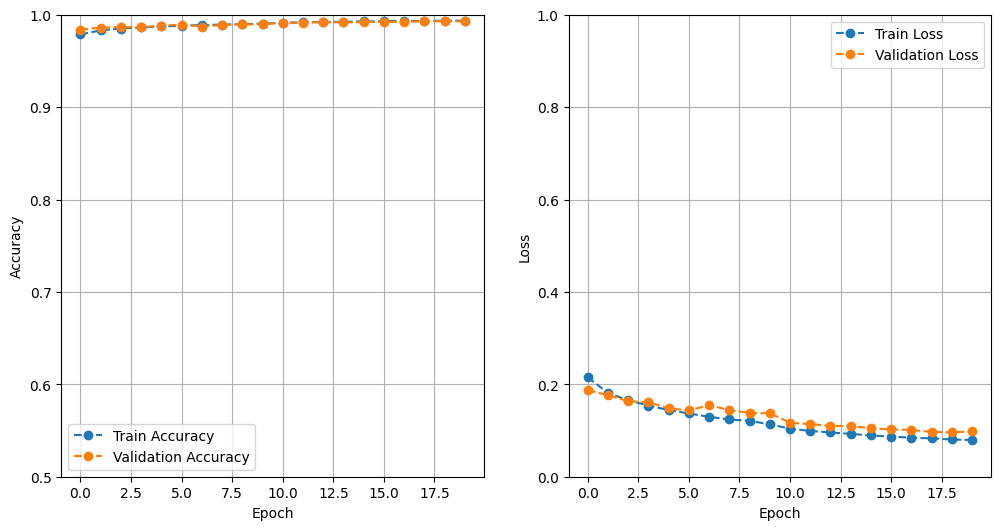

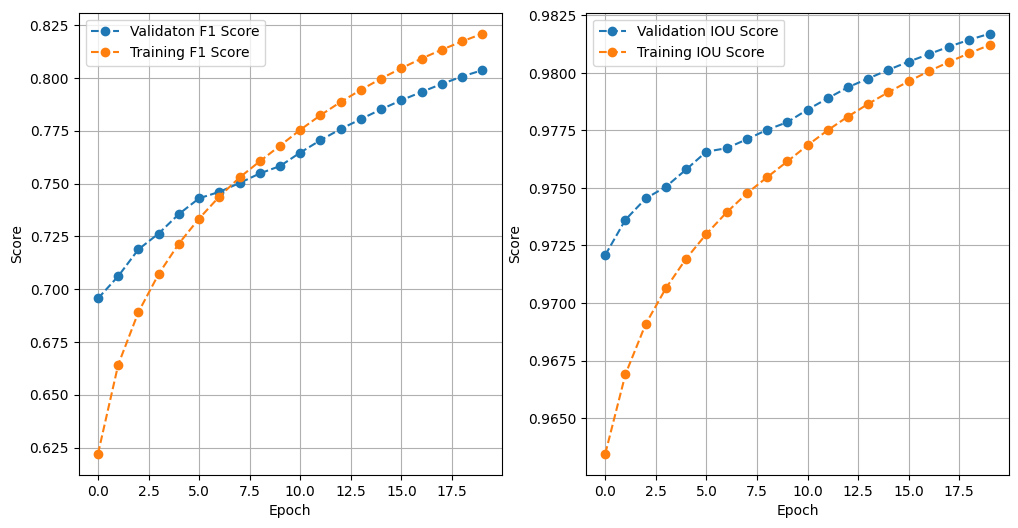

In [ ]:
# %%

if model_training:
    train(
        model,
        images_augmented,
        labels_augmented,
        images_validation,
        labels_validation,
        loss_func=BCEIoULoss(),
        batch_size=4,
        learning_rate=2e-4,
        epochs=20,
        model_validation=model_validation,
        cuda_available=cuda_available,
        path_model=path_model,
    )

if model_loading:
    # Load the model from your Google Drive or local file system
    checkpoint = torch.load(path_model)
    model.load_state_dict(checkpoint["model_state_dict"])

In [ ]:
# %%

submission = submission_creating(
    model, path_testing, training_resize, testing_resize, cuda_available
)

100%|██████████| 5/5 [00:00<00:00,  6.39it/s]


In [ ]:
# %%

np.savetxt("submit.csv", submission, delimiter=",", fmt="%s")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1218894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0033040235..1.0847623].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0004824306..1.075873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1066992].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0760508].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3341668].


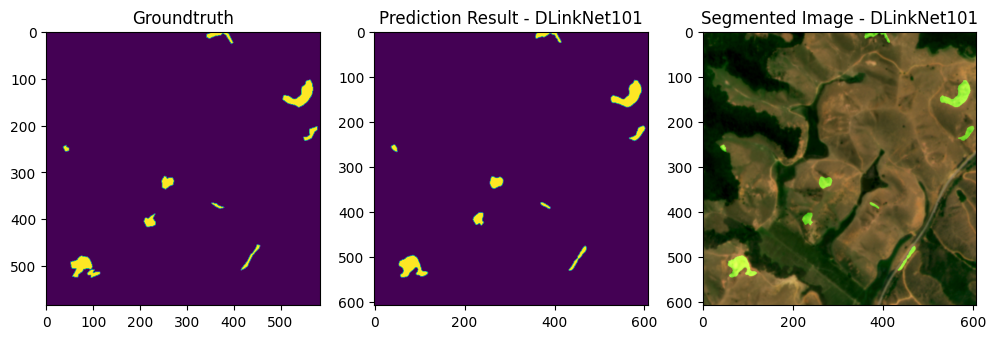

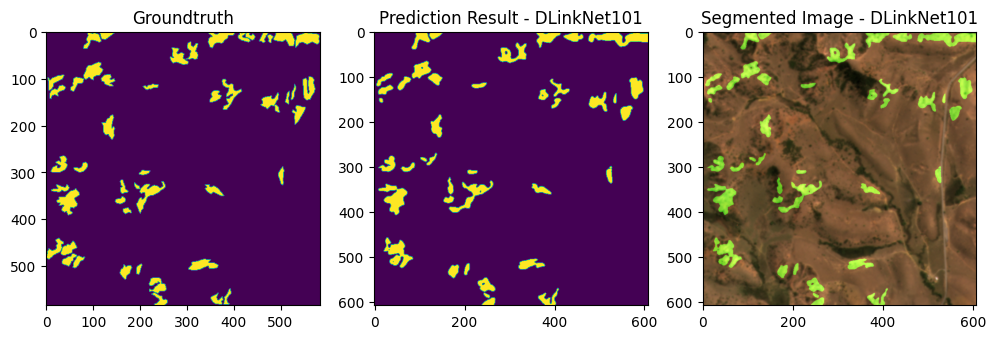

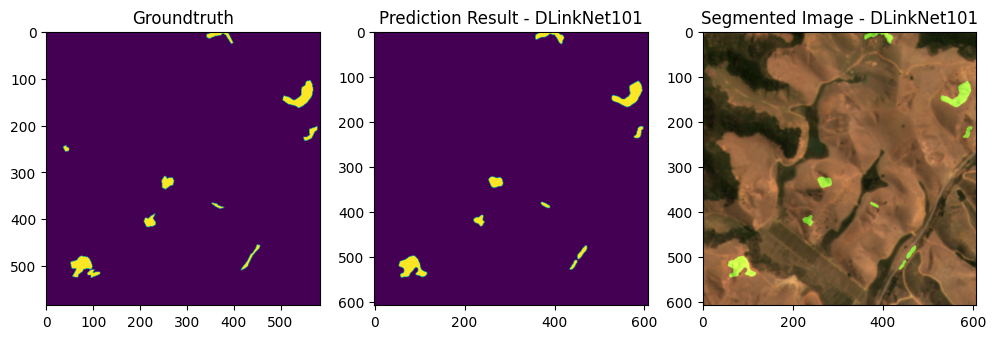

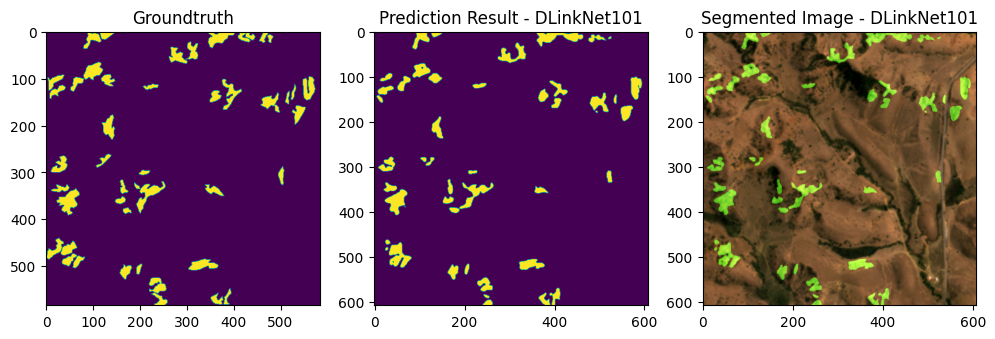

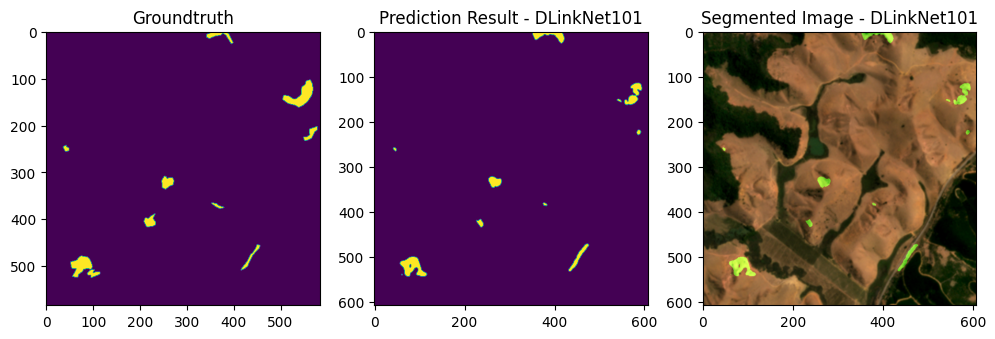

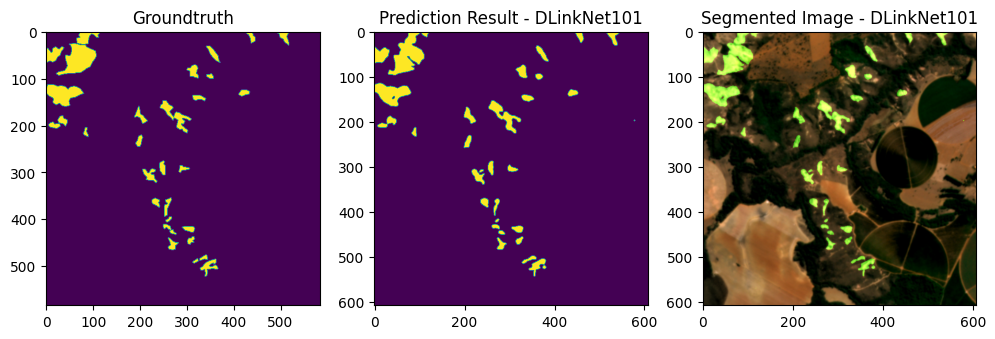

In [ ]:
# %%

for aux in range(747, 753):
    test(path_testing, aux, model, cuda_available)